<font size = 6><i>Classification de chiffres et comptage de mots</i></font>

Beaucoup de jeux de données sont de très grandes tailles, et faire des calculs dessus nécessite énormément de temps. Certains algorithmes sont décomposables en opérations élementaires, ce qui facilite la gestion des calculs assez lourds.

Le but du TP est de voir quelques méthodes qui simplifient les grands calculs sur des grosses bases de données.


# A-] Classification de chiffres
--

Pour montrer l'intérêt de la parallélisation, il faut d'abord télécharger un grand jeu de données.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# tensorflow est une librairie qui est assez connue pour l'apprentissage statistique, notamment les réseaux de neurones
# on l'utilisera juste pour charger les données

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

/home/drone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


11493376/11490434 [==============================] - 11s 1us/step


Ce jeu de données est une base de données d'images représentant des chiffres de 1 à 9 contenue dans x, accompagné d'une série de labels de "0" à "9" contenus dans y.

x_train[1] contient la première image sous forme de pixels (1 image = 28 pixels*28 pixels), y_train[1] le libellé du premier chiffre.

<b>1) Pour s'en convaincre, affichez les premières images à l'aide de la fonction imshow() de matplotlib</b>

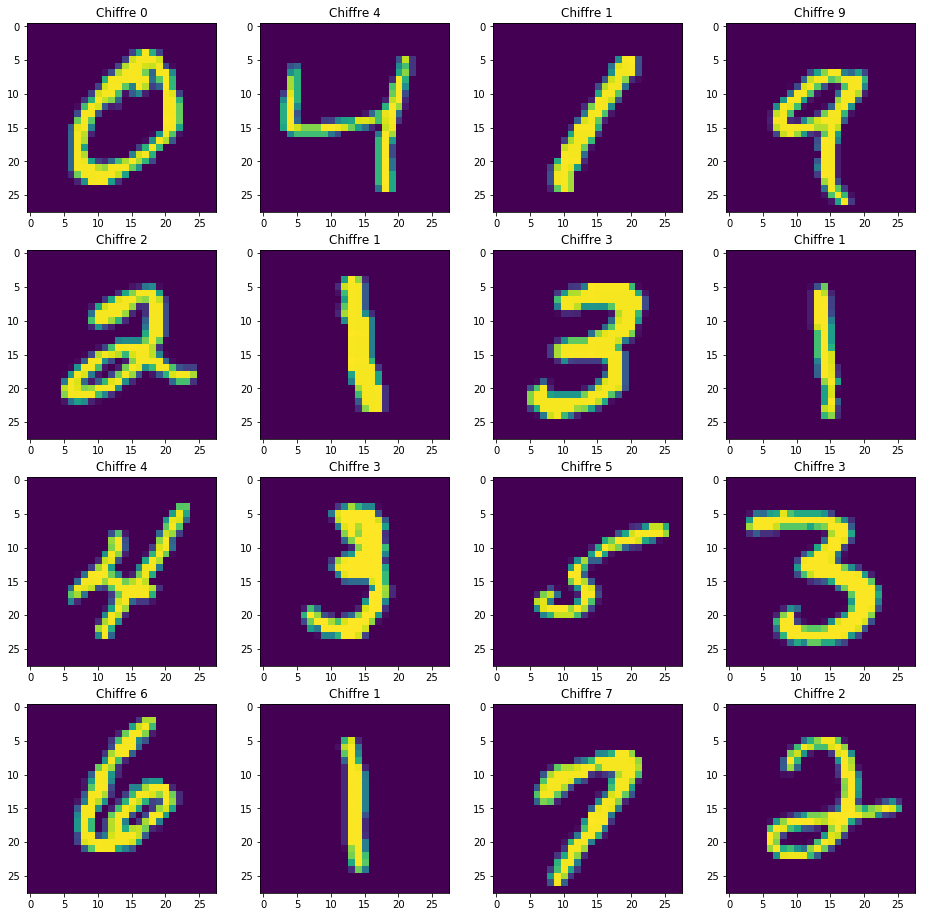

In [2]:
taille = 4
plt.subplots(nrows=taille,ncols=taille,figsize=(taille*taille,taille*taille)) # on crée une grille de 4*4 = 16 graphes

for i in range(taille): # i va de 0 à 3
    for j in range(taille): # j va de 0 à 3
        indice = i*taille+j+1 # donc i*4+j+1 va de 1 à 16
        
        plt.subplot(taille,taille,indice) # Pour chaque case
        plt.imshow(x_train[indice]) # on affiche chaque image
        plt.title('Chiffre '+str(y_train[indice])) # Et on ajoute un titre
plt.show()

Oui, mais dans cette base de données énorme, chaque calcul prend du temps. On va essayer de quantifier ce temps.

<b>2) Par exemple, cherchez la probabilité de tomber sur le chiffre 1 dans y_train, et calculez le temps pris par votre calcul à  l'aide de la fonction clock() de la librairie time.</b>

La fonction en elle-même, pour récupérer les probabilités de présence de chacun des chiffres.

In [3]:
chiffre = []
for i in range(10):
    effectifChiffre = len(y_train[np.where(y_train==i)])
    longueurTable = len(y_train)
    proba = effectifChiffre/longueurTable
    chiffre.append("Proba "+str(i)+" = "+str(proba))
chiffre

['Proba 0 = 0.09871666666666666',
 'Proba 1 = 0.11236666666666667',
 'Proba 2 = 0.0993',
 'Proba 3 = 0.10218333333333333',
 'Proba 4 = 0.09736666666666667',
 'Proba 5 = 0.09035',
 'Proba 6 = 0.09863333333333334',
 'Proba 7 = 0.10441666666666667',
 'Proba 8 = 0.09751666666666667',
 'Proba 9 = 0.09915']

On prend le temps initial deb au début du bloc d'instructions, et le temps final fin à la fin. Le temps écoulé vaut la différence "temps de fin moins temps de début".

In [4]:
import time

deb = time.clock() # On prend le temps de départ

chiffre = []

for i in range(10):
    effectifChiffre = len(y_train[np.where(y_train==i)])
    longueurTable = len(y_train)
    proba = effectifChiffre/longueurTable
    chiffre.append(proba)
    
fin = time.clock() # On prend le temps final

print("L'instruction a pris "+str(fin-deb)+ " secondes.")

L'instruction a pris 0.0032250000000004775 secondes.


<b>3) Cette instruction tourne plutôt vite. Comment se comporte le temps quand on fait une grosse opération? Faites une analyse en composantes principales avec le package PCA, et affichez les points à l'aide de matplotlib.</b>
    
Il peut être utile de formater les données dans un premier temps, de sorte qu'une image soit écrite dans une seule ligne dans votre base de données, et pas dans un tableau de 28*28. Pour cela, pensez à utiliser la fonction reshape de numpy.

Si vous vous sentez à l'aise: tracer des ellipses autour des groupes de points pour "marquer les limites" des groupes.

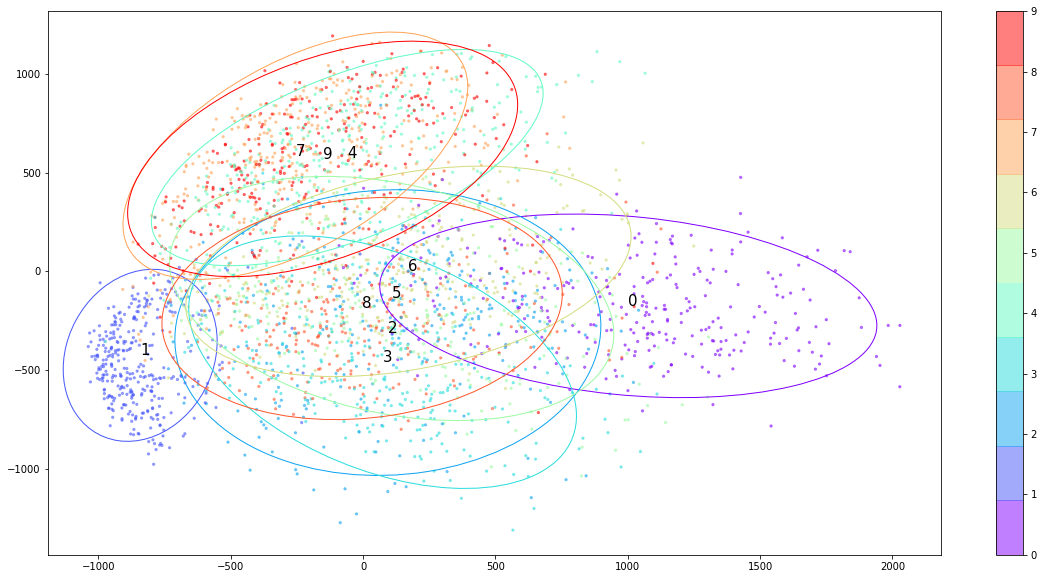

L'ACP a pris 3.628749 secondes.


In [5]:
from sklearn.decomposition import PCA

deb = time.clock() # On prend le temps de départ

X = x_train.reshape(60000,28*28)# format des données suivant 784 colonnes et 60k lignes

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X) 




################ Partie optionnelle, pour faire plus "joli"

from matplotlib.patches import Ellipse

plt.figure(figsize=(20,10))
ax = plt.subplot(111)

cmap = plt.get_cmap('rainbow', 10) # palette de couleur, une couleur = un chiffre

# Dessiner les ellipses

def eigsorted(cov): 
    # détermine les valeurs propres et les vecteurs propres associés à la matrice cov, 
    # et les renvoie dans l'ordre décroissant selon les valeurs propres
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

for i in range(10): # pour chaque chiffre
    x = pca_result[np.where(y_train==i), 0] # coordonnées sur le premier axe
    y = pca_result[np.where(y_train==i), 1] # coordonnées sur le second axe
    
    cov = np.cov(x, y) # covariance des coordonnées
    vals, vecs = eigsorted(cov) # vals pour les valeurs propres, vecs pour les vecteurs propres
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1])) # la rotation
    w, h = 4 * np.sqrt(vals) # dispersions du nuage de points, vient déterminer les hauteurs/largeurs de l'ellipse
    
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),# centre de l'ellipse
                  width=w,#largeur
                  height=h,#hauteur
                  angle=theta,
                  color=cmap(range(10))[i]) # on récupère la cmap de l'analyse factorielle
    ell.set_facecolor('none') # ellipse vide pour  voir les points
    plt.text(np.mean(x), np.mean(y),str(i),size=15) # texte des chiffres
    ax.add_artist(ell) # on ajoute chaque ellipse au graphe

############################### Fin de la partie optionnelle







nbPoints = 3000 # nombre de points représentés par le plan. À 60000 on y voit rien!
plt.scatter(pca_result[:nbPoints, 0], # coordonnées sur le premier axe
            pca_result[:nbPoints, 1], # coordonnées sur le second axe
            c=y_train[:nbPoints], # les chiffres pour les couleurs
            alpha=0.5,#transparence
            cmap=cmap, #palette de correspondance
            s=5)# size
plt.colorbar() # la barre de couleur à droite
plt.show()

fin = time.clock() # On prend le temps final

print("L'ACP a pris "+str(fin-deb)+ " secondes.")

L'idée avec l'ACP du dessus, c'est de définir des groupes d'images correspondant aux chiffres. Les ellipses entourent les groupes de points qui sont représentés par les mêmes labels. Si deux ellipses se coupent, cela signifie que l'on peut "confondre" les deux chiffres considérés, et prendre l'un pour l'autre. Par exemple, sur les images, on confond souvent le 4, le 9 et le 7. Au contraire, le 1 est bien isolé.

Ici, l'ACP prend un peu plus de temps, car elle fait des calculs matriciels sur des grandes dimensions.


<b> 4) Maintenant, on va comparer le temps d'éxécution d'une opération lancée sur un coeur , au temps d'exécution de la même opération répartie entre plusieurs coeurs. Pour cela , on va utiliser la fonction K-means, vu dans le tp précédent, qui fait de la classification des individus (ici de la classification des chiffres).

Dans la logique, il faudrait penser à faire 10 groupes de points, pour que chaque groupe isolé par les kmeans correspondent à un chiffre. Prenez le réflexe d'aller fouiller dans la doc, en l'occurence dans ce cas-là: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


 

Cette fonction dipose d'une option n_jobs qui permet de partager les calculs entre plusieurs coeurs. A priori, le nombre maximal pour n_jobs est le nombre de coeurs que possède votre ordinateur. Pour déterminer le nombre de coeurs:
- https://www.it-connect.fr/afficher-le-nombre-de-coeurs-sous-linux/ pour linux 
- https://support.microsoft.com/fr-fr/help/4026757/windows-10-find-out-how-many-cores-your-processor-has pour windows

Testez un algorithme de KMeans lancé avec l'option n_jobs = 1, puis le même algo avec n_jobs = votre nombre de coeurs, et comparez les temps d'exécution.


Je vous conseille de lancer un htop depuis linux pour voir comment les coeurs sont utilisés par l'algorithme suivant les différentes configurations (ou le gestionnaire des tâches sous windows).</b>

# Attention:
Ne prenez que quelques milliers de ligne pour démarrer, sinon l'algorithme prendra trop de temps (10 000 max).

Pour un seul job

In [8]:
from sklearn.cluster import KMeans
import pandas as pd

nbPoints = 6000
X = x_train.reshape(60000,28*28)[:nbPoints,:]
y = y_train[:nbPoints]

deb = time.clock() # On prend le temps de départ

kmeans = KMeans(n_clusters = 10, # 10 groupes de points pour des chiffres allant de 0 à 9 inclus
                n_jobs = 1) # seul 1 coeur à 100% fait tourner l'algorithme

kmeans.fit(X)

fin = time.clock() # On prend le temps final

print("L'algorithme a pris "+str(fin-deb)+ " secondes.")

L'algorithme a pris 7.8590610000000005 secondes.


La version à quatre jobs

In [9]:
from sklearn.cluster import KMeans
import pandas as pd



nbPoints = 6000
X = x_train.reshape(60000,28*28)[:nbPoints,:]
y = y_train[:nbPoints]
deb = time.clock() # On prend le temps de départ
kmeans = KMeans(n_clusters = 10, # 10 groupes de points pour des chiffres allant de 0 à 9 inclus
                n_jobs = -1) # 4 coeurs à 25% chacun font tourner l'algorithme

kmeans.fit(X)

fin = time.clock() # On prend le temps final

print("L'algorithme a pris "+str(fin-deb)+ " secondes.")

L'algorithme a pris 0.8227539999999998 secondes.


<b> 5) Si vous avez le temps, essayez de faire varier n_jobs et et le nombre de lignes. Puis représentez graphiquement tous les temps d'exécution sur un même graphe, en fonction de n_jobs.
    
Sinon, passez directement au B-].</b>

In [14]:
from sklearn.cluster import KMeans
import pandas as pd


# Si ça tourne vite, vous pouvez mettre des tailles plus importantes
# Au contraire, si c'est lent, essayez avec des tableaux de taille plus réduites
nbPoints = np.array((2000,4000,8000,16000))



tailleLigne = len(nbPoints)
tailleCoeur= 4 # le nombre de coeurs max de votre pc


temps = np.zeros(tailleLigne*tailleCoeur).reshape(tailleLigne,tailleCoeur)

for indicept in range(tailleLigne):
    for nbCoeur in range(1,tailleCoeur+1):
        
        nbpt = nbPoints[indicept] 
        # Comme les algos sont gourmands en temps de calcul, 
        # on se restreint à un échantillon de nbpt points
    
        X = x_train.reshape(60000,28*28)[:nbpt,:]
        y = y_train[:nbpt]

        deb = time.clock() # On prend le temps de départ

        kmeans = KMeans(n_clusters = 10, # 10 groupes de points pour des chiffres allant de 0 à 9 inclus
                        n_jobs = nbCoeur) # Le nombre de coeurs utilisés
        kmeans.fit(X)

        fin = time.clock() # On prend le temps final
        
        temps[indicept,nbCoeur-1] = fin-deb

        print("L'exécution avec ", nbCoeur, "job(s) sur ", nbpt, " lignes a mis ", fin-deb, " secondes.")

L'exécution avec  1 job(s) sur  2000  lignes a mis  3.6916570000000206  secondes.
L'exécution avec  2 job(s) sur  2000  lignes a mis  0.37587500000000773  secondes.
L'exécution avec  3 job(s) sur  2000  lignes a mis  0.35871199999999703  secondes.
L'exécution avec  4 job(s) sur  2000  lignes a mis  0.3629589999999894  secondes.
L'exécution avec  1 job(s) sur  4000  lignes a mis  6.097839000000022  secondes.
L'exécution avec  2 job(s) sur  4000  lignes a mis  0.601680000000016  secondes.
L'exécution avec  3 job(s) sur  4000  lignes a mis  0.6244709999999998  secondes.
L'exécution avec  4 job(s) sur  4000  lignes a mis  0.6213349999999878  secondes.
L'exécution avec  1 job(s) sur  8000  lignes a mis  11.280766999999997  secondes.
L'exécution avec  2 job(s) sur  8000  lignes a mis  1.343057000000016  secondes.
L'exécution avec  3 job(s) sur  8000  lignes a mis  1.0711300000000108  secondes.
L'exécution avec  4 job(s) sur  8000  lignes a mis  1.0726790000000221  secondes.
L'exécution avec 

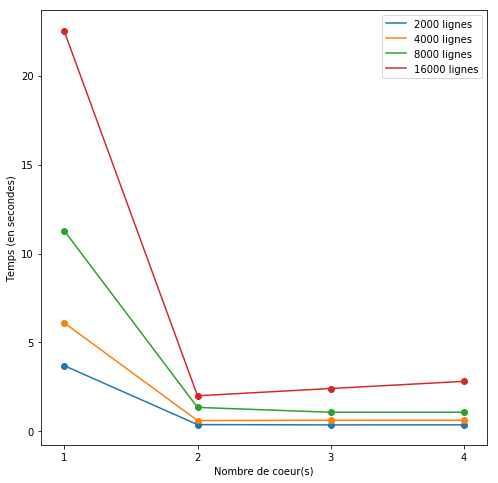

Temps (en secondes) : 


,1 coeur(s),2 coeur(s),3 coeur(s),4 coeur(s)
nb_lignes,,,,
2000 lignes,3.691657,0.375875,0.358712,0.362959
4000 lignes,6.097839,0.601680,0.624471,0.621335
8000 lignes,11.280767,1.343057,1.071130,1.072679
16000 lignes,22.505823,1.997098,2.405148,2.809893


In [15]:
indiceCoeur = range(1,tailleCoeur+1) 
# on crée l'indice des coeurs, qui va en abcisses
resultats = pd.DataFrame(data=temps, columns = [str(k)+ " coeur(s)" for k in indiceCoeur])
# Puis on crée une base de données à partir des temps récupérés dans le bloc précédent
resultats.loc[:,"nb_lignes"] = [str(k)+' lignes' for k in nbPoints]
# On crée notre futur indice de tables, le nombre de lignes de la base considérée

plt.figure(figsize=(8,8))
# Et on affiche le graphique
for i in range(tailleLigne):
    # Pour chaque taille de base donnée à  l'algo
    tab = np.array(resultats.iloc[i,range(tailleCoeur)])
    # On crée un tableau correspondant aux données de la ligne
    plt.scatter(indiceCoeur, tab)
    # on affiche les points
    plt.plot(indiceCoeur, tab)
    # on les relie
plt.legend(resultats["nb_lignes"])
# On indique la signification des courbes
plt.ylabel("Temps (en secondes)")
plt.xlabel("Nombre de coeur(s)")
plt.xticks(indiceCoeur) # Pour éviter le 3.5 coeur, qui ne correspond à rien
plt.show()

# Puis la table correspondante
print("Temps (en secondes) : ")
resultats.set_index('nb_lignes')

Cet algorithme est sympathique, au sens où il gère pour vous toute la partie décomposition des opérations. Si vous voulez répartir les opérations sur plusieurs coeurs, il faut dire manuellement à chaque coeur de quoi il doit s'occuper à l'aide de threads. 

Voir https://openclassrooms.com/fr/courses/235344-apprenez-a-programmer-en-python/2235545-la-programmation-parallele-avec-threading si vous souhaitez aller plus loin sur le sujet. 

(Bonus)
<b> 6) Introduction au machine learning : Utilisez l'ACP des questions précédentes pour prédire les chiffres représentés sur les photos qui n'ont pas été utilisées pour construire le modèle. Combien avez-vous d'erreurs? </b>

On pourra utiliser la fonction predict() associée à PCA.

# B-] Comptage de mots avec Spark


C'est quoi spark? C'est un environnement de calculs distribués. Il permet, à l'image des questions précédentes, de décomposer les gros calculs en une multitude de petits calculs qui s'éxécutent en parallèle.

Pour l'installation, qui n'est pas évidente à suivre:
http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx2/td_3a_spark.html

In [2]:
Ce code ne doit être exécuté qu'une fois. La variable sc est alors notre interface spark, qui tourne en local.import findspark
findspark.init("C:\\Users\\llesoil\\Downloads\\spark") # à remplacer par votre SPARK_HOME, l'emplacement de spark
import pyspark
sc = pyspark.SparkContext(appName="TP3")

Ce code ne doit être exécuté qu'une fois. La variable sc est alors notre interface spark, qui tourne en local.

In [3]:
s = 'ils ont des chapeaux ronds '+ 'vive la Bretagne '+'ils ont des chapeaux ronds '+ 'vive les bretons' 
sc.parallelize(s.split()).map(lambda word: (word, 1)).reduceByKey(lambda a,b:a+b).collect()

[('la', 1),
 ('ronds', 2),
 ('Bretagne', 1),
 ('les', 1),
 ('chapeaux', 2),
 ('vive', 2),
 ('ils', 2),
 ('ont', 2),
 ('bretons', 1),
 ('des', 2)]

Le [schéma](https://github.com/llesoil/modelisation_des_problemes_scientifiques-/blob/master/Aides/mapreduce.png), tiré de ce [tuto](https://nyu-cds.github.io/python-bigdata/02-mapreduce/) explique bien le principe du mapreduce, un algorithme utilisé par spark qui permet de distribuer des calculs.:

- On répartit les données entre les différentes machines (s'il y a quatre machines, on peut supposer que chacune s'occupe d'une phrase dans notre cas), c'est le mapping
- Chacun récupère les mots de sa phrase à partir de la chaine de caractère (le .split() découpe la chaine suivant les espaces)
- Chacun compte ses mots individuellement, c'est le map
- Puis on passe à la phase reduce, on additionne tous les comptes des mots associés aux quatre phrases (reducebKey)
- Enfin, on peut afficher les résultats du dessous

L'intérêt, c'est que <B>toute la partie mapping peut se faire en parallèle</B>. 

Si vous avez un roman à analyser, ça sera plus rapide si chaque ordinateur s'occupe d'un chapitre, comparé à une analyse séquentielle.

In [4]:
import os

path = os.getcwd() + "//"+"loutre_des_mers.txt" 
# os.getcwd() donne l'adresse du répertoire courant
# Vous pouvez télécharger le fichier loutre_des_mers.txt et mettre l'adresse locale dans la variable path

file = sc.textFile(path)
# Crée le fichier à partir du chemin

output = file.flatMap(lambda line: line.split(" ")).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b).collect()

# on affiche les dix premiers mots
for (word, count) in output[0:10]:
        print("%s: %i" % (word, count))

loutre: 6
mer: 6
lutris): 1
est: 2
des: 6
must�lid�s): 1
vivant: 1
dans: 3
le: 3
du: 5


Le code fonctionne également avec un fichier texte.

<b>1) Appliquez le même code au fichier twitter_trump.txt, qui contient des tweets concernant/de Donald Trump pris sur http://www.trumptwitterarchive.com/archive. Quels sont les mots qui reviennent le plus fréquemement? Est-ce Barack Obama ou Hillary Clinton qui est le.a plus cité.e dans ce fichier?</b>

Indications:
- On pourra utiliser des dictionnaires, la fonction sorted() pourra sans doute vous aider. 
- Si vous voulez de meilleurs résultats, vous pouvez utiliser la fonction lower() sur chacun des mots pour enlever les majuscules, et le module stop_words pour ne pas tenir compte des mots les plus couramment utilisés en anglais.

In [5]:
from stop_words import get_stop_words

path = os.getcwd() + "//"+"twitter_trump.txt" 

file = sc.textFile(path)

output = file.flatMap(lambda line: line.split(" ")).map(lambda word: (word.lower(), 1)).reduceByKey(lambda a, b: a + b).collect()
# on rajoute un lower pour ne pas tenir compte des majuscules
# ce qui peut créer des doublons de mots

stop_words = get_stop_words('en') # Pour enlever les mots les plus communs

comptage = dict()
# le dictionnaire est le format le plus pratique pour traiter des données qui ont la forme clef, valeur

for mot, compte in output: # pour chaque couple mot, comptage du mot
    if mot not in stop_words: # si le mot n'est pas dans les stop_words
        comptage[mot] = compte # on l'ajoute dans la liste


print('Obama est cité ',comptage['barack']+comptage['obama'], ' fois.')
print('Clinton est citée ',comptage['hillary']+comptage['clinton'], ' fois.')
print('Les mots les plus utilisés dans les tweets : ')
sorted(comptage, key = comptage.get, reverse=True)[0:20]

Obama est cité  1061  fois.
Clinton est citée  921  fois.
Les mots les plus utilisés dans les tweets : 


['',
 'will',
 'great',
 '&amp;',
 '-',
 'just',
 'thank',
 'trump',
 'people',
 'new',
 'obama',
 'get',
 'big',
 'now',
 'make',
 'can',
 'many',
 'like',
 'good',
 'via']

<b> 2) Estimation de la constante pi à l'aide de Spark<b>